所需 python 依赖

In [5]:
from importlib.metadata import version

pkgs = [
    "tqdm",
    "numpy",
    "torch",
    "pandas",
    "tiktoken",
    "tokenizers",
    "tensorflow",
    "matplotlib",
    "huggingface_hub",  
]

for p in pkgs:
    print(f"{p} version: {version(p)}")

tqdm version: 4.67.1
numpy version: 2.3.2
torch version: 2.8.0+cu129
pandas version: 2.3.1
tiktoken version: 0.11.0
tokenizers version: 0.22.0
tensorflow version: 2.20.0
matplotlib version: 3.10.5
huggingface_hub version: 0.34.4


一、编写 GPT-small（124M）架构

In [ ]:
import torch
import torch.nn as nn

GPT_CONFIG_124M = {
    "vocab_size": 50257,    # 词汇表维度
    "context_length": 256, # 上下文长度
    "emb_dim": 768,         # 编码维度
    "n_heads": 12,          # 注意力头数
    "n_layers": 12,         # transformer 层数
    "drop_rate": 0.1,       # 丢弃率
    "qkv_bias": False       # k、q、v 偏置
}
# 归一化层 
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
# GELU 激活函数
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))
# 前馈网络
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)
# 多头注意力
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x) 
        queries = self.W_query(x)
        values = self.W_value(x)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec
    
# transformer 块
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
# 模型架构
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

二、实体化模型，不加载预训练的权重


In [7]:
import tiktoken
from previous_chapters import generate_text_simple

torch.manual_seed(123)#代码设置了一个随机种子，确保可复现
model = GPTModel(GPT_CONFIG_124M)#模型实体化
model.eval();#设置为评估模式

#定义两个转化函数：
#将文本转换为tokenID
def text_to_token_ids(text,tokenizer):
    encoded = tokenizer.encode(text,allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor
#将tokenID转换为文本
def token_ids_to_text(token_ids,tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"#提示词
start_context_1 = "Who are you?"
tokenizer = tiktoken.get_encoding("gpt2")#初始化分词器

#获取模型输出的tokenID并用分词器进行解码，返回文本信息
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context,tokenizer),
    max_new_tokens=30,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n",token_ids_to_text(token_ids,tokenizer))
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context_1,tokenizer),
    max_new_tokens=30,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n",token_ids_to_text(token_ids,tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren Mortgage TT remember gard ACTIONSussedOND Land Engeleddedemate breaths proxies GalaxyForm therapies drying consultants FrazierVPN
Output text:
 Who are you? Wisdom Stores instability firepoweromblehem  Barron expression Floating circumcision TT Telegram tweakingAllen lifelong systemic salt Tek accountedud sharp exacerbate discusses FE hammeredipal keepsiesel Tarant


In [8]:
# 可用设备
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)
with device:
    model = GPTModel(GPT_CONFIG_124M)

# 计算模型中所有可训练参数的元素总数
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameter:{total_params:,}")#冒号后面加逗号是格式说明符，作用是千位分隔符
# 减去词嵌入共享的参数，输入词嵌入层 (tok_emb) 和输出的分类头 (out_head) 共享同一套权重矩阵，上一步的计算中重复了这部分数量
total_params_normalized = total_params - model.tok_emb.weight.numel()
print(f"Total number of unique parameters:{total_params_normalized:,}")

#计算模型显存占用
def model_memory_size(model,input_dtype=torch.float32):
    #初始化参数和梯度的元素计数器
    total_params = 0
    total_grads = 0
    #遍历所有模型参数
    for param in model.parameters():
        param_size = param.numel()
        total_params += param_size

        if param.requires_grad:
            total_grads += param_size
    #计算所有缓冲区的元素总数
    total_buffers = sum(buf.numel() for buf in model.buffers())
    #获取指定数据类型单个元素的大小
    element_size = torch.tensor(0,dtype=input_dtype).element_size()
    #计算总字节数
    # 这里将 参数元素数 + 梯度元素数 + 缓冲区元素数 相加，再乘以每个元素的大小
    total_memory_bytes = (total_params + total_grads +total_buffers) * element_size
    #转换为GB单位
    total_memory_gb = total_memory_bytes / (1024**3)
    return total_memory_gb

print(f"float32 (Pytorch default): {model_memory_size(model,input_dtype=torch.float32):.2f} GB")
print(f"bfloat16: {model_memory_size(model,input_dtype=torch.bfloat16):.2f} GB")

cuda
Total number of parameter:162,419,712
Total number of unique parameters:123,822,336
float32 (Pytorch default): 1.21 GB
bfloat16: 0.61 GB


三、加载预训练数据集

In [9]:
from previous_chapters import create_dataloader_v1

file_path = "the-verdict.txt"
with open(file_path,"r",encoding='utf-8') as file:
        text_data = file.read()
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(text_data[:99])
print(text_data[-99:])
print("Characters:",total_characters)
print("Token:",total_tokens)
#分割数据集，90%作为训练数据集，10%作为验证数据集
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))#计算数据集分割点
train_data = text_data[:split_idx]#训练数据
val_data = text_data[split_idx:]#验证数据

torch.manual_seed(123)

#创建训练数据加载器
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,#如果最后剩下的数据不够一个batch，就丢弃
    shuffle=True,#在每个epoch前打乱数据顺序，增强模型泛化能力
    num_workers=0
)
#创建验证数据加载器
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,#不丢弃数据
    shuffle=False,#不打乱数据
    num_workers=0
)
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokend for the training loader."
          "Try to lower the 'GPT_CONFIG_124M['context_length']' or"
          "increase the 'training_ratio'")
    
if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader."
          "Try to lower the 'GPT_CONFIG_124M['context_length']' or"
          "decrease the 'train_ratio'")
#计算训练集和验证集的token数
train_tokens = 0
for input_batch,target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch,target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:",train_tokens)
print("Validation tokens:",val_tokens)
print("All tokens:",train_tokens+val_tokens)

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 
it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."
Characters: 20479
Token: 5145
Training tokens: 4608
Validation tokens: 512
All tokens: 5120


四、计算在当前数据集上的 loss

In [10]:
#函数：计算单个批次的损失
def calc_loss_batch(input_batch,target_batch,model,device):
    input_batch,target_batch = input_batch.to(device),target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1),target_batch.flatten())
    return loss
#函数：计算整个数据加载器的平均损失
def calc_loss_loader(data_loader,model,device,num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches,len(data_loader))
    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch,target_batch,model,device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.manual_seed(123)
#计算模型当前对训练数据集和验证数据集的损失，进行评估，并非训练阶段，因此无需计算梯度更新模型权重
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device)
    val_loss = calc_loss_loader(val_loader,model,device)
#当前模型对两个数据集的损失都很大，模型此时的性能很差
print("Training loss:",train_loss)
print("Validation loss:",val_loss)

Training loss: 10.962354024251303
Validation loss: 10.953326225280762


五、对 LLM 进行预训练——学习通用的语言能力

In [11]:
def train_model_simple(model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq,eval_iter,start_context,tokenizer):
    #初始化记录器
    train_losses,val_losses,track_tokens_seen = [],[],[]
    tokens_seen,global_step = 0,-1
    #外层循环：训练轮数
    for epoch in range(num_epochs):
        model.train()
        #内层循环：批次
        for input_batch,target_batch in train_loader:
            #把梯度清零
            optimizer.zero_grad()
            #前向传播，计算损失
            loss = calc_loss_batch(input_batch,target_batch,model,device)
            #反向传播，计算梯度
            loss.backward()
            #更新模型权重
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1
            #每经过一定批次（eval_freq），就用验证数据集对模型进行一次评估
            if global_step % eval_freq == 0:
                train_loss,val_loss = evaluate_model(model,train_loader,val_loader,device,eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1}(Step{global_step:06d}):"
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
                
        generate_and_print_sample(model,tokenizer,device,start_context)

    return train_losses,val_losses,track_tokens_seen

#函数：评估模型表现
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
    #切换到评估模式
    model.eval()
    #无需更新梯度，计算模型在两个数据集上的损失
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader,model,device,num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader,model,device,num_batches=eval_iter)
    #切换到训练模式
    model.train()
    return train_loss,val_loss

#函数：生成样本
def generate_and_print_sample(model,tokenizer,device,start_context):
    #评估模式
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context,tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids,tokenizer)
    print(decoded_text.replace("\n"," "))#打印生成的文本信息
    #训练模式
    model.train()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=0.0004,weight_decay=0.1)#lr：学习率；weight_decay:正则化技术，防止模型过拟合

num_epochs = 10
train_losses,val_losses,tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,#评估的频率,单位batch
    eval_iter=5,#评估的数据量，单位batch
    start_context="Every effort moves you",
    tokenizer=tokenizer
)

Ep 1(Step000000):Train loss 9.820, Val loss 9.927
Ep 1(Step000005):Train loss 8.066, Val loss 8.338
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2(Step000010):Train loss 6.624, Val loss 7.050
Ep 2(Step000015):Train loss 6.049, Val loss 6.603
Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3(Step000020):Train loss 5.559, Val loss 6.494
Ep 3(Step000025):Train loss 5.428, Val loss 6.384
Every effort moves you, and to the to the of the to the, and I had. Gis, and, and, and, and, and, and I had, and, and, and, and, and, and, and, and, and,
Ep 4(Step000030):Train loss 4.974, Val loss 6.285
Ep 4(Step000035):Train loss 4.721, Val loss 6.303
Every effort moves you of the picture.      "I                "I"I the picture"I had the picture"I the picture and I had been the picture of
Ep 5(Step000040):Train loss 4.058, Val loss 6.159
Every effort moves you know the                          "Oh, and the fact a little the latter the h

六、绘制 loss 图像

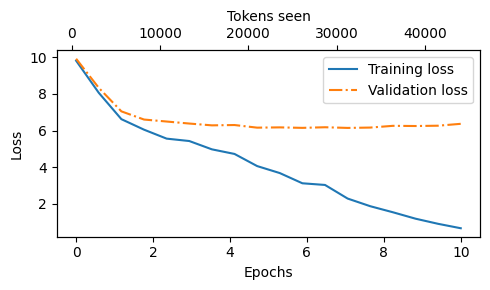

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator\
#函数：将损失绘制为一幅图
def plot_losses(epochs_seen,tokens_seen,train_losses,val_losses):
    #创建图标和坐标轴
    fig,ax1 = plt.subplots(figsize=(5,3))
    #在第一个坐标轴 ax1 上绘制损失曲线
    ax1.plot(epochs_seen,train_losses,label="Training loss")
    ax1.plot(epochs_seen,val_losses,linestyle='-.',label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    #创建共享 Y 轴的第二个 X 轴
    ax2 = ax1.twiny()
    #在第二个坐标轴 ax2 上绘制一个“隐形”的图，用于设置刻度
    ax2.plot(tokens_seen,train_losses,alpha=0)
    ax2.set_xlabel("Tokens seen")
    #调整布局并显示/保存
    fig.tight_layout()
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0,num_epochs,len(train_losses))
plot_losses(epochs_tensor,tokens_seen,train_losses,val_losses)

In [14]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you",tokenizer),
    max_new_tokens=30,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("(1)Output text:\n",token_ids_to_text(token_ids,tokenizer))

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Who are you?",tokenizer),
    max_new_tokens=30,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("(2)Output text:\n",token_ids_to_text(token_ids,tokenizer))

(1)Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"

He laughed again, and
(2)Output text:
 Who are you? I'd never touched a brush."

"I told Mrs.

"Once, when I looked up, I seemed to see a smile
